In [133]:
import jax
import jax.numpy as jnp  # JAX NumPy
import jax.random as random

from flax import linen as nn  # The Linen API

import numpy as np  # Ordinary NumPy
import optax  # Optimizers
import matplotlib.pyplot as plt

import blackjax

%matplotlib inline

In [36]:
model = nn.Dense(features=1)

In [37]:
model

Dense(
    # attributes
    features = 1
    use_bias = True
    dtype = None
    param_dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
)

In [38]:
key1, key2 = random.split(random.PRNGKey(0))
x = random.normal(key1, (1,)) # Dummy input
params = model.init(key2, x) # Initialization call
jax.tree_map(lambda x: x.shape, params) # Checking output shapes

FrozenDict({
    params: {
        bias: (1,),
        kernel: (1, 1),
    },
})

In [32]:
params

FrozenDict({
    params: {
        kernel: DeviceArray([[2.1127698]], dtype=float32),
        bias: DeviceArray([0.], dtype=float32),
    },
})

The bias seems to be 0. Let us do something about it.

In [183]:
model = nn.Dense(
    features=1,
    kernel_init=jax.nn.initializers.kaiming_uniform(),
    bias_init=jax.nn.initializers.normal(),
)

model
params = model.init(key2, x)  # Initialization call
jax.tree_map(lambda x: x.shape, params)  # Checking output shapes

FrozenDict({
    params: {
        bias: (1,),
        kernel: (1, 1),
    },
})

In [184]:
params

FrozenDict({
    params: {
        kernel: DeviceArray([[2.4043102]], dtype=float32),
        bias: DeviceArray([-0.00810676], dtype=float32),
    },
})

In [71]:
n_samples = 100
xs = jnp.linspace(-2, 2, n_samples).reshape(-1, 1)

### Creating training dataset
#### Method 1

In [72]:
f = jnp.dot(xs, params['params']['kernel']) + params['params']['bias']
y = f + random.normal(key = random.PRNGKey(0), shape = (n_samples,1))

#### Method 2 (using model.apply)

In [81]:
f = model.apply(params,xs)
y = f + random.normal(key = random.PRNGKey(0), shape = (n_samples,1))

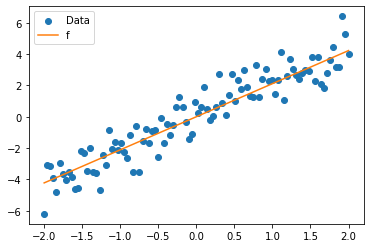

In [82]:
plt.scatter(xs, y, label='Data')
plt.plot(xs, f, label='f', color='C1')
plt.legend()

In [83]:
params

FrozenDict({
    params: {
        kernel: DeviceArray([[2.1127698]], dtype=float32),
        bias: DeviceArray([0.], dtype=float32),
    },
})

In [84]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

In [191]:
prior = {}
for k, val in params['params'].items():
    prior[k] = tfd.Normal(loc = jnp.zeros_like(val), scale = 1., )

In [192]:
prior

{'kernel': <tfp.distributions.Normal 'Normal' batch_shape=[1, 1] event_shape=[] dtype=float32>,
 'bias': <tfp.distributions.Normal 'Normal' batch_shape=[1] event_shape=[] dtype=float32>}

In [193]:
def eval_logprior(prior, params):
    k = params['params']['kernel']
    b = params['params']['bias']
    return (prior['kernel'].log_prob(k) + prior['bias'].log_prob(b)).item()

In [194]:
eval_logprior(
    prior, params
)

-4.728263854980469

In [204]:
def eval_ll(model, params, x, y):
    d = tfd.Normal(loc = model.apply(freeze(params), x), scale=1.)
    return d.log_prob(y).sum()

In [205]:
eval_ll(model, params, x, y)

DeviceArray(-465.15082, dtype=float32)

In [206]:
def eval_log_joint(params, model, prior, x, y):
    return eval_logprior(prior, params) + eval_ll(model, params, x, y)


from functools import partial

eval_log_joint_partial = partial(eval_log_joint, model=model, prior=prior, x=x, y=y)

In [207]:
eval_log_joint(params, model, prior, x, y)

DeviceArray(-469.8791, dtype=float32)

In [208]:
from flax.core.frozen_dict import freeze, unfreeze

In [209]:
rng_key = random.PRNGKey(314)

params_init = unfreeze(model.init(rng_key, x))


rmh = blackjax.rmh(eval_log_joint_partial, sigma=jnp.ones(2) * 0.7)
initial_state = rmh.init(params_init)

In [210]:
initial_state

RMHState(position={'params': {'bias': DeviceArray([-0.0119987], dtype=float32), 'kernel': DeviceArray([[1.1413311]], dtype=float32)}}, log_probability=DeviceArray(-464.6161, dtype=float32))

In [211]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [212]:
_, rng_key = random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 5_000)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/1)>
The problem arose with the `float` function. If trying to convert the data type of a value, try using `x.astype(float)` or `jnp.array(x, float)` instead.
While tracing the function one_step at /var/folders/1x/wmgn24mn1bbd2vgbqlk98tbc0000gn/T/ipykernel_79354/41124006.py:2 for scan, this concrete value was not available in Python because it depends on the values of the arguments 'state' and 'rng_key'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [179]:
initial_state

RMHState(position=FrozenDict({
    params: {
        kernel: DeviceArray([[0.67063206]], dtype=float32),
        bias: DeviceArray([0.], dtype=float32),
    },
}), log_probability=DeviceArray(-463.95422, dtype=float32))

In [219]:
tfp.distributions

SyntaxError: invalid syntax (876586393.py, line 1)